In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


### Review

In [235]:
load('../ps4/cfb.RData')

The *point spread* is defined as winning team's points minus the losing team's points. For conference games, plot the distribution of point spread for each conference.

In [239]:
# Your code here

# Lecture 08: Tidy data
<div style="border: 1px double black; padding: 10px; margin: 10px">

**After today's lecture you will:**
* Understand what makes [tidy data](#Tidy-data) and why we care
* [Gather](#Gather) multiple columns into one
* [Spread](#Spread) one column into several
* [Separate](#Separate) and [unite](#Unite) columns
* Impute [missing values](#Missing-values)
</div>




## Tidy data
There are many different ways to represent data in a table, but some are better than others.
We say that a data table is "[tidy](http://vita.had.co.nz/papers/tidy-data.pdf)" if:
- Each row represents an observation.
- Each column represents a variable.
- Each value gets its own cell.
- Each different type of data set gets its own table.

Data tables which are not tidy are called messy!
![http://r4ds.had.co.nz/images/tidy-1.png](http://r4ds.had.co.nz/images/tidy-1.png)

Every column is a variable: tidy.

In [2]:
print(table1)

# A tibble: 6 x 4
  country      year  cases population
  <chr>       <int>  <int>      <int>
1 Afghanistan  1999    745   19987071
2 Afghanistan  2000   2666   20595360
3 Brazil       1999  37737  172006362
4 Brazil       2000  80488  174504898
5 China        1999 212258 1272915272
6 China        2000 213766 1280428583


Variables are entries in the type column: messy.

In [3]:
print(table2) # 

# A tibble: 12 x 4
   country      year type            count
   <chr>       <int> <chr>           <int>
 1 Afghanistan  1999 cases             745
 2 Afghanistan  1999 population   19987071
 3 Afghanistan  2000 cases            2666
 4 Afghanistan  2000 population   20595360
 5 Brazil       1999 cases           37737
 6 Brazil       1999 population  172006362
 7 Brazil       2000 cases           80488
 8 Brazil       2000 population  174504898
 9 China        1999 cases          212258
10 China        1999 population 1272915272
11 China        2000 cases          213766
12 China        2000 population 1280428583


The cases and population variables are combined in the rate column: (sort of) messy.

In [4]:
print(table3)

# A tibble: 6 x 3
  country      year rate             
* <chr>       <int> <chr>            
1 Afghanistan  1999 745/19987071     
2 Afghanistan  2000 2666/20595360    
3 Brazil       1999 37737/172006362  
4 Brazil       2000 80488/174504898  
5 China        1999 212258/1272915272
6 China        2000 213766/1280428583


The cases and population variables are in two separate tables. 

In [5]:
print(table4a) # cases in one tibble
writeLines("\n")
print(table4b) # population in another one

# A tibble: 3 x 3
  country     `1999` `2000`
* <chr>        <int>  <int>
1 Afghanistan    745   2666
2 Brazil       37737  80488
3 China       212258 213766


# A tibble: 3 x 3
  country         `1999`     `2000`
* <chr>            <int>      <int>
1 Afghanistan   19987071   20595360
2 Brazil       172006362  174504898
3 China       1272915272 1280428583


Recapping: tidy data means

* each observation has its own row
* each variable has its own column
* each value has its own cell

## Why we care about tidy data
The tools we have learned so far all live in the `tidyverse`. This means that each tool expect to recieve tidy data as input, and, where necessary, returns tidy data as output. You can think of tidy data as a sort of contract that everything in `tidyverse` respects. This makes it possible to string many tidyverse commands together using `%>%`  (without having to worry too much about whether it will work.)

The mutate command expects tidy data and returns tidy data.

In [39]:
mutate(table1, rate = cases / population * 10000) # rate of cases per 10000 people

  country     year cases  population rate    
1 Afghanistan 1999    745   19987071 0.372741
2 Afghanistan 2000   2666   20595360 1.294466
3 Brazil      1999  37737  172006362 2.193930
4 Brazil      2000  80488  174504898 4.612363
5 China       1999 212258 1272915272 1.667495
6 China       2000 213766 1280428583 1.669488

How would we calculate the `rate` variable using `table2`?

In [7]:
print(table2)
# mutate(table2, rate=???)

# A tibble: 12 x 4
   country      year type            count
   <chr>       <int> <chr>           <int>
 1 Afghanistan  1999 cases             745
 2 Afghanistan  1999 population   19987071
 3 Afghanistan  2000 cases            2666
 4 Afghanistan  2000 population   20595360
 5 Brazil       1999 cases           37737
 6 Brazil       1999 population  172006362
 7 Brazil       2000 cases           80488
 8 Brazil       2000 population  174504898
 9 China        1999 cases          212258
10 China        1999 population 1272915272
11 China        2000 cases          213766
12 China        2000 population 1280428583


Summary commands like `summarize` and `count` also preserve tidy data:

In [8]:
count(table1, year, wt = cases) # compute no. of cases for each year

  year n     
1 1999 250740
2 2000 296920

`ggplot` also expects tidy data:

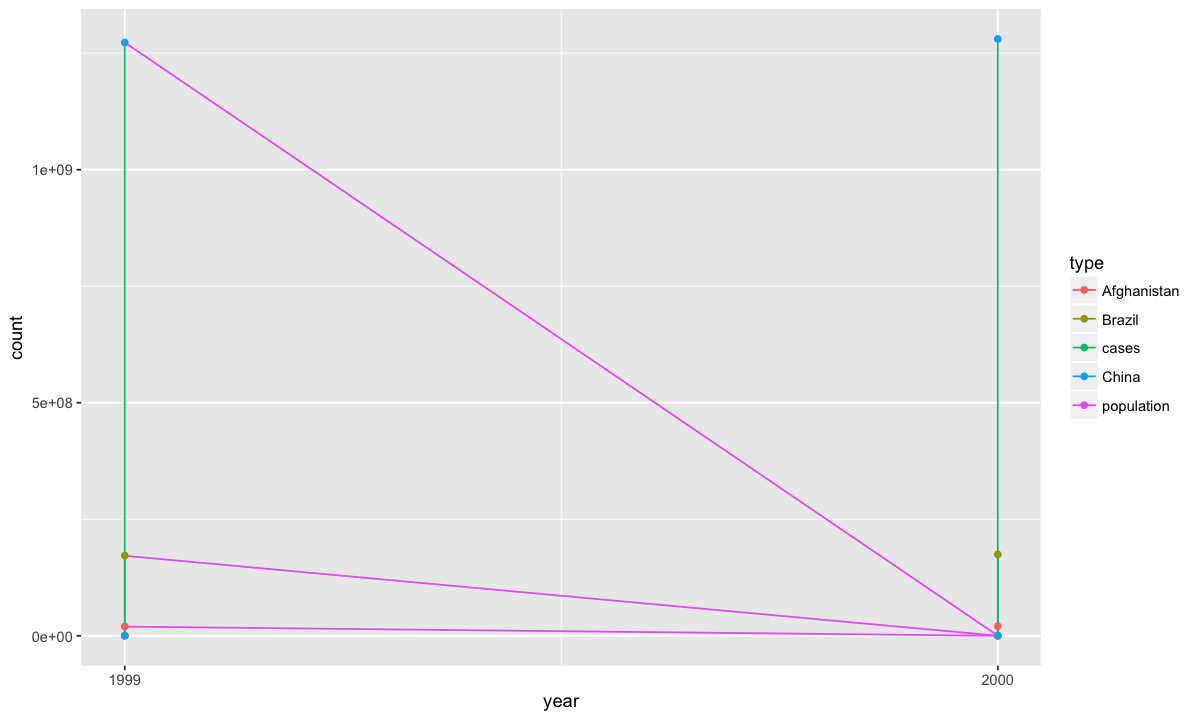

In [43]:
ggplot(table2, aes(x=year, y=count, color=type)) +
    geom_line(aes(group = country)) +
    geom_point(aes(color = country)) +
    scale_x_continuous(breaks=c(1999, 2000))

## Creating tidy data
If the data is not already tidy, then we might need to some work before we can use the tools in `dplyr`. The package `tidyr` inside `tidyverse` allows one to convert data into the tidy data.

### Gather
One common problem in when a variable is spread across multiple columns and we need to gather those columns to create a new pair of variables. For example, consider `table4a` from above:

In [219]:
# We will learn about spread below.
table1_wide <- table1 %>% select(country, year, cases) %>% 
    spread(key=year, value=cases) 

In [220]:
table1_wide

  country     1999   2000  
1 Afghanistan    745   2666
2 Brazil       37737  80488
3 China       212258 213766

Here there is a year variable which is spread across two columns. To become tidy, it should get its own `year` column. We want to *gather* the columns of year into a single column.
![gather illustration](http://r4ds.had.co.nz/images/tidy-9.png)

The command to do this is called `gather()`. To use `gather()` we need to specify three things:

* which existing columns correspond to values of a variable
* what is the name of the variable (the **key**) whose values currently appear as column names.
* what is the name of the variable (the **value**) whose values are currently spread over the cells.

(When using `gather()`, neither the **key** nor **value** column names currently exist in your data. They are "destination" columns in the new table.)

In [45]:
gather(table1_wide, key = year, value = cases, `1999`, `2000`)

  country     year cases 
1 Afghanistan 1999    745
2 Brazil      1999  37737
3 China       1999 212258
4 Afghanistan 2000   2666
5 Brazil      2000  80488
6 China       2000 213766

### Exercise
Transform `table4b` to tidy format:

In [19]:
table4b

  country     1999       2000      
1 Afghanistan   19987071   20595360
2 Brazil       172006362  174504898
3 China       1272915272 1280428583

In [20]:
# Your code here

### Separate
Sometimes we encounter wide data where there are multiple identifiers in a column name:

In [151]:
(stocks <- tibble(
  year   = c(2015, 2015, 2016, 2016),
  profit_q1 = c(1.881,0.592,0.921,0.170),
  profit_q2 = c(0.957,0.147,1.391,0.762),
  revenue_q3 = c(1.876,0.655,0.337,0.588),
  revenue_q4 = c(2.365,0.642,0.294,0.566)
))
stocks %>% gather(key = pq, value = value, -year) %>% separate(pq, into=c("type", "qtr")) %>% print(n=3)

  year profit_q1 profit_q2 revenue_q3 revenue_q4
1 2015 1.881     0.957     1.876      2.365     
2 2015 0.592     0.147     0.655      0.642     
3 2016 0.921     1.391     0.337      0.294     
4 2016 0.170     0.762     0.588      0.566     

# A tibble: 16 x 4
   year type   qtr   value
  <dbl> <chr>  <chr> <dbl>
1  2015 profit q1    1.88 
2  2015 profit q1    0.592
3  2016 profit q1    0.921
# ... with 13 more rows


### Exercise
Use `gather()` to get the `stocks` table into the following semi-tidy format:

```
# A tibble: 16 x 3
   year pq        value
  <dbl> <chr>     <dbl>
1  2015 profit_q1 1.88 
2  2015 profit_q1 0.592
3  2016 profit_q1 0.921
# ... with 13 more rows
```

In [135]:
# Your code here

To pull apart these two variables we have the `separate()` function. `separate()` takes the name of the column to separate, a separator (in this case `'/'`), and the names of the columns to separate into. Example:

In [143]:
table5

  country     century year rate             
1 Afghanistan 19      99   745/19987071     
2 Afghanistan 20      00   2666/20595360    
3 Brazil      19      99   37737/172006362  
4 Brazil      20      00   80488/174504898  
5 China       19      99   212258/1272915272
6 China       20      00   213766/1280428583

The `rate` column is really holding two columns of data: `cases` and `population`. To split them up, we can run `separate()`:

In [152]:
separate(table5, col = rate, into = c("cases", "population"), sep = "/") %>% print

# A tibble: 6 x 5
  country     century year  cases  population
* <chr>       <chr>   <chr> <chr>  <chr>     
1 Afghanistan 19      99    745    19987071  
2 Afghanistan 20      00    2666   20595360  
3 Brazil      19      99    37737  172006362 
4 Brazil      20      00    80488  174504898 
5 China       19      99    212258 1272915272
6 China       20      00    213766 1280428583


By default, `separate()` has coded `cases` and `population` as strings. To do further analysis we should convert them to numbers using the `convert=TRUE` option:

In [154]:
separate(table5, col = rate, into = c("cases", "population"), 
         sep = "/", convert = T) %>% print

# A tibble: 6 x 5
  country     century year   cases population
* <chr>       <chr>   <chr>  <int>      <int>
1 Afghanistan 19      99       745   19987071
2 Afghanistan 20      00      2666   20595360
3 Brazil      19      99     37737  172006362
4 Brazil      20      00     80488  174504898
5 China       19      99    212258 1272915272
6 China       20      00    213766 1280428583


### Exercise
Use `separate()` to get `stocks` to tidy format:

```
# A tibble: 16 x 4
   year type   qtr   value
  <dbl> <chr>  <chr> <dbl>
1  2015 profit q1    1.88 
2  2015 profit q1    0.592
3  2016 profit q1    0.921
# ... with 13 more rows
```

### Exercise
Reproduce the following plot showing the joint distribution of winning and losing scores for each game in `cfb`:
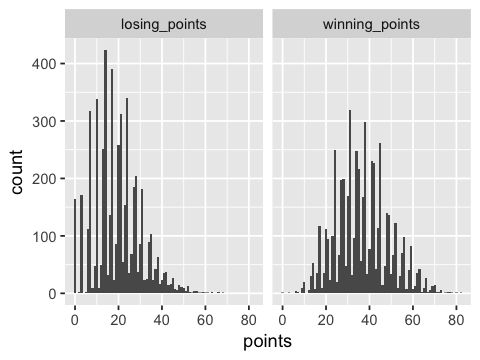

In [234]:
# Your code here

### Exercise
Which team in CFB has the most wins? Fewest?

In [ ]:
# Your code here

### Spread
Another type of problem is when an observation is scattered across multiple rows.

In [155]:
print(table2)

# A tibble: 12 x 4
   country      year type            count
   <chr>       <int> <chr>           <int>
 1 Afghanistan  1999 cases             745
 2 Afghanistan  1999 population   19987071
 3 Afghanistan  2000 cases            2666
 4 Afghanistan  2000 population   20595360
 5 Brazil       1999 cases           37737
 6 Brazil       1999 population  172006362
 7 Brazil       2000 cases           80488
 8 Brazil       2000 population  174504898
 9 China        1999 cases          212258
10 China        1999 population 1272915272
11 China        2000 cases          213766
12 China        2000 population 1280428583


Here we want to do the opposite of gather: we want to *spread* these rows out into new columns.
![spread data](http://r4ds.had.co.nz/images/tidy-8.png)

We need to specify two things:

* which existing column (the **key**) has the variable names as values
* which existing column (the **value**) has the values for those variables

What is the key here? What is the value?

In [162]:
print(table2, n=5)

# A tibble: 12 x 4
  country      year type          count
  <chr>       <int> <chr>         <int>
1 Afghanistan  1999 cases           745
2 Afghanistan  1999 population 19987071
3 Afghanistan  2000 cases          2666
4 Afghanistan  2000 population 20595360
5 Brazil       1999 cases         37737
# ... with 7 more rows


### Exercise
Convert `table2` to tidy format using `spread()`.

In [163]:
# Your code here

Remember that:

* `gather` tends to make wide tables narrower and longer
* `spread` tends to make long tables shorter and wider
* `gather` and `spread` are inverses -- each one undos the other.

Sometimes we want to `spread()` data for other reasons. Some tables are more readable if they are put in a non-tidy format. This is often the case with time data.

### Exercise
Use `spread()` to put the `year` variable of `table1` into columns (show `population` only):
```
  country     1999       2000      
1 Afghanistan   19987071   20595360
2 Brazil       172006362  174504898
3 China       1272915272 1280428583
```

In [184]:
# Your code here

### Exercise
Re-create the following table which shows monthly departures from the three NYC airports:
```
  origin 1    2    3     4     5     6     7     8     9    10    11   12  
1 EWR    9893 9107 10420 10531 10592 10175 10475 10359 9550 10104 9707 9922
2 JFK    9161 8421  9697  9218  9397  9472 10023  9983 8908  9143 8710 9146
3 LGA    7950 7423  8717  8581  8807  8596  8927  8985 9116  9642 8851 9067
```

In [173]:
# Your code here

### Exercise
Is the table below tidy? If not, how should we tidy it?

In [164]:
(preg = tribble(
  ~pregnant, ~male, ~female,
  "yes",     NA,    10,
  "no",      20,    12
))

  pregnant male female
1 yes      NA   10    
2 no       20   12    

### Spreading more than one column
Consider the following simple table:

In [194]:
grades <- tribble(
    ~person, ~exam, ~q1, ~q2, ~q3,
    "alice", "mt1", 1, 2, 3.5,
    "alice", "mt2", .5, 2.5, 1.5,
    "bob", "mt1", 0.0, 1.0, 1.5,
    "bob", "mt2", 1.5, 2.5, 2.0
)

# A tibble: 4 x 5
  person exam     q1    q2    q3
  <chr>  <chr> <dbl> <dbl> <dbl>
1 alice  mt1     1     2     3.5
2 alice  mt2     0.5   2.5   1.5
3 bob    mt1     0     1     1.5
4 bob    mt2     1.5   2.5   2  


In [221]:
print(grades)

# A tibble: 4 x 5
  person exam     q1    q2    q3
  <chr>  <chr> <dbl> <dbl> <dbl>
1 alice  mt1     1     2     3.5
2 alice  mt2     0.5   2.5   1.5
3 bob    mt1     0     1     1.5
4 bob    mt2     1.5   2.5   2  


Suppose we want to expand this into multiple columns `mt1.q1`, `mt1.q2`, and so on. How should we use `spread()`?

In [193]:
grades %>% spread(key=exam, value=q1)

  person q2  q3  mt1 mt2
1 alice  2.0 3.5  1   NA
2 alice  2.5 1.5 NA  0.5
3 bob    1.0 1.5  0   NA
4 bob    2.5 2.0 NA  1.5

We have uncovered a limitation of `spread()`. It can only operate on a single key-value pair. (This is on purpose, in order to keep the command simple.)

### Unite
To `spread()` multiple values at once we'll use the `unite()` command to combine them into a single variable. The unite command does the opposite of `separate()`: stick several variables together to form a new variable.

In [195]:
unite(grades, col="q", q1:q3)

  person exam q          
1 alice  mt1  1_2_3.5    
2 alice  mt2  0.5_2.5_1.5
3 bob    mt1  0_1_1.5    
4 bob    mt2  1.5_2.5_2  

`unite()` has taken each of the values q1, q2, q3 and combined them into a single column. Now we can `spread()` the `q` column to obtain:

In [196]:
unite(grades, col="q", q1:q3) %>% spread(key=exam, value=q)

  person mt1     mt2        
1 alice  1_2_3.5 0.5_2.5_1.5
2 bob    0_1_1.5 1.5_2.5_2  

### Exercise
Use `separate()` on this table to complete the exercise and obtain:
```
  person mt1.q1 mt1.q2 mt1.q3 mt2.q1 mt2.q2 mt2.q3
1 alice  1      2      3.5    0.5    2.5    1.5   
2 bob    0      1      1.5    1.5    2.5    2     
```

In [208]:
# Your code here

## Missing Values
Missing values can be:

* **Explicit** (marked as `NA` in our data); or
* **Implicit** (not present in the data).

In [90]:
(stocks <- tibble(
  year   = c(2015, 2015, 2015, 2015, 2016, 2016, 2016),
  qtr    = c(   1,    2,    3,    4,    2,    3,    4),
  return = c(1.88, 0.59, 0.35,   NA, 0.92, 0.17, 2.66)
))

  year qtr return
1 2015 1   1.88  
2 2015 2   0.59  
3 2015 3   0.35  
4 2015 4     NA  
5 2016 2   0.92  
6 2016 3   0.17  
7 2016 4   2.66  

In this example we have one explicitly missing value for the 4th quarter of 2015. Are there any other missing values? Yes, because we do not have an observation for the first quarter of 2016.

The **complete** command makes implicit missing value explicit by considering all combinations of unique values of specified variables.

In [34]:
complete(stocks, year, qtr) 

  year qtr return
1 2015 1   1.88  
2 2015 2   0.59  
3 2015 3   0.35  
4 2015 4     NA  
5 2016 1     NA  
6 2016 2   0.92  
7 2016 3   0.17  
8 2016 4   2.66  

The missing values also become explicit if we **spread** the tibble.

In [35]:
spread(stocks, key = year, value = return)

  qtr 2015 2016
1 1   1.88   NA
2 2   0.59 0.92
3 3   0.35 0.17
4 4     NA 2.66

**gather** will keep all these explicitly missing values by default.

In [36]:
stocks %>%
    spread(key = year, value = return) %>%
    gather(`2015`, `2016`, key = year, value = return)

  qtr year return
1 1   2015 1.88  
2 2   2015 0.59  
3 3   2015 0.35  
4 4   2015   NA  
5 1   2016   NA  
6 2   2016 0.92  
7 3   2016 0.17  
8 4   2016 2.66  

If you don't like the default behavior of **gather**, you can turn off explicit missing values using the `na.rm` argument.

In [37]:
stocks %>%
    spread(key = year, value = return) %>%
    gather(`2015`, `2016`, key = year, value = return, na.rm = TRUE)

  qtr year return
1 1   2015 1.88  
2 2   2015 0.59  
3 3   2015 0.35  
6 2   2016 0.92  
7 3   2016 0.17  
8 4   2016 2.66  